In [95]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import gc
import time

from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, \
                    KFold, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, \
                    AdaBoostClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import SGDClassifier, LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, \
                KBinsDiscretizer, Binarizer, PolynomialFeatures, quantile_transform, power_transform

from catboost import CatBoostClassifier, Pool, cv
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
import xgboost
import lightgbm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, BayesianRidge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

In [96]:
# load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
data = pd.read_csv('tabular_data.csv')
feature = pd.read_csv('hashed_feature.csv')

### clear and prepare data

In [97]:
# feature 50, tranform hash to numeric 
feature['feature_50'] = feature['feature_50'].map(lambda x: hash(str(x)))
feature[:1]

,id,feature_50
0,0,-7320801361389487764


100%|██████████| 9/9 [00:14<00:00,  1.62s/it]


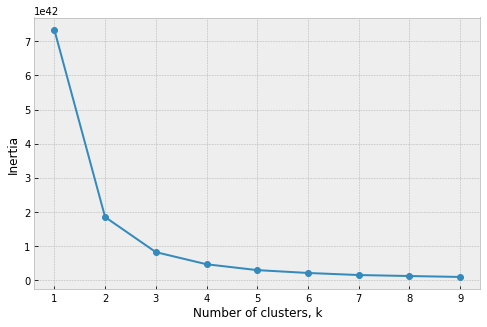

In [138]:
# check for the better value of k
ks = range(1, 10)
inertias = []
for k in tqdm(ks):
    model = KMeans(n_clusters=k)
    model.fit(feature)
    inertias.append(model.inertia_)
plt.figure(figsize=(8,5))
plt.style.use('bmh')
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show();

In [99]:
# final model for # of 4 clusters
final_model = KMeans(n_clusters=4, random_state=11)

In [100]:
# fit 
final_model.fit(feature)

KMeans(n_clusters=4, random_state=11)

In [101]:
# predict for labels and fill the data
feature['cluster'] = final_model.predict(feature)

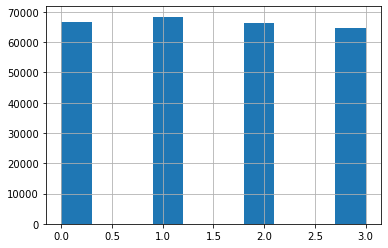

In [102]:
# check the distrib
feature['cluster'].hist()
plt.show()

In [103]:
# aggregate the cluster values
feature_50_cluster = feature.groupby('id')['cluster'].mean()
# add to data 
data['feature_50_cluster'] = feature_50_cluster
# fill nan
data = data.fillna(0)

In [104]:
# transform feature 25 to One Hot
feature_25 = pd.get_dummies(data.feature_25, prefix='feature_25')

In [105]:
# check the shapes 
feature_25.shape, data.shape

((5106, 53), (61272, 8), (61272, 53))

In [106]:
# concat the DF
data_ = pd.concat([data, feature_25], axis=1)
# make an average for all observation
data_ = data_.groupby('id')[data_.columns].mean()
# add target
data_['target'] = train.target
# drop period
data_.drop('period', axis=1, inplace=True)

In [124]:
# select the data with target values 
data_train = data_[:4084]
data_test = data_[4084:]

### prepare data and models pipe

In [125]:
X_train, X_test, y_train, y_test = train_test_split(data_train.drop('target', axis=1), data_train.target, \
                                                    test_size=0.15, random_state=11)
gc.collect()

2933

In [131]:
n_jobs = -1
random_state = 11 

### PIPELINE 
pipe_rf = Pipeline([('rf', RandomForestClassifier(random_state=random_state, n_jobs=n_jobs))])

pipe_ada = Pipeline([('ada', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), \
                                                random_state=random_state))])

pipe_gbc = Pipeline([('gbc', GradientBoostingClassifier(random_state=random_state))])

pipe_ext = Pipeline([('ext', ExtraTreesClassifier(random_state=random_state, n_jobs=n_jobs))])

pipe_cat = Pipeline([('cat', CatBoostClassifier(random_state=random_state, verbose=False))])

pipe_bag = Pipeline([('bag', BaggingClassifier(n_jobs=n_jobs, random_state=random_state))])

pipe_svc = Pipeline([('svc', SVC(random_state=random_state, probability=True))])

pipe_xgb = Pipeline([('xgb', xgboost.XGBClassifier(n_jobs=n_jobs, random_state=random_state))])

pipe_lgh = Pipeline([('lgh', lightgbm.LGBMClassifier(n_jobs=n_jobs, random_state=random_state))])

### PARAMS
cv = StratifiedKFold(shuffle=False, n_splits=5, random_state=11)

grid_params_rf = [{
                'rf__criterion': ['entropy'],
                'rf__min_samples_leaf': list(range(2, 7, 2)),
                'rf__max_depth': list(range(5, 20, 5)),
                'rf__n_estimators' : list(range(100, 200, 10))
                }]
                
grid_params_ada = [{
                'ada__learning_rate' : [0.8, 0.9],
                'ada__n_estimators': [200, 300]
                }]

grid_params_gbc = [{
                'gbc__learning_rate' : list(np.linspace(0.1, 0.2, 3)),
                'gbc__n_estimators' : list(range(100, 200, 25)),
                'gbc__max_depth' : list(range(1, 4, 1))
                }]

grid_params_ext = [{
                'ext__min_samples_leaf': list(range(5, 15, 2)),
                'ext__max_depth': list(range(16, 20, 2)),
                'ext__n_estimators' : list(range(150, 200, 25))
                }]

grid_params_cat = [{
                'cat__learning_rate' : list(np.linspace(0.001, 0.01, 5)),
                'cat__iterations': [1500],
                'cat__depth': list(range(9, 12, 3)),
                'cat__l2_leaf_reg':list(np.linspace(3, 5, 1))
                }]

grid_params_bag = [{'bag__base_estimator': [KNeighborsClassifier()],
                'bag__n_estimators': [70, 90] #list(range(10, 80, 10))
                    }]

grid_params_svc = [{
                    'svc__C': [2, 4]
                    }]

grid_params_xgb = [{
                'xgb__max_depth': list(range(1,4,3)),
                'xgb__learning_rate': list(np.linspace(0.001, 0.01, 5)),
                'xgb__n_estimators': list(range(200, 300, 50)),
                'xgb__min_child_weight': list(range(1, 3, 1))
                
                    }]
                                      
grid_params_lgh = [{'lgh__learning_rate': list(np.linspace(0.01, 0.1, 4)),
                    'lgh__boosting_type': ['gbdt', 'goss'],
                    'lgh__max_depth': list(range(5, 10, 5)),
                    'lgh__n_estimators': list(range(10, 40, 10))
                    }]                                                                     
### Grid search 

gs_rf = RandomizedSearchCV(pipe_rf, param_distributions=grid_params_rf,
                     scoring='roc_auc', cv=cv, n_iter=15)

gs_ada = RandomizedSearchCV(pipe_ada, param_distributions=grid_params_ada,
                     scoring='roc_auc', cv=cv, n_iter=15)

gs_gbc = RandomizedSearchCV(pipe_gbc, param_distributions=grid_params_gbc,
                     scoring='roc_auc', cv=cv, n_iter=15)

gs_ext = RandomizedSearchCV(pipe_ext, param_distributions=grid_params_ext,
                     scoring='roc_auc', cv=cv, n_iter=15)

gs_cat = RandomizedSearchCV(pipe_cat, param_distributions=grid_params_cat,
                     scoring='roc_auc', cv=cv, n_iter=15)

gs_bag = RandomizedSearchCV(pipe_bag, param_distributions=grid_params_bag,
                     scoring='roc_auc', cv=cv, n_iter=15)

gs_svc = RandomizedSearchCV(pipe_svc, param_distributions=grid_params_svc,
                     scoring='roc_auc', cv=cv, n_iter=15)

gs_xgb = RandomizedSearchCV(pipe_xgb, param_distributions=grid_params_xgb,
                     scoring='roc_auc', cv=cv, n_iter=15)
                                      
gs_lgh = RandomizedSearchCV(pipe_lgh, param_distributions=grid_params_lgh,
                     scoring='roc_auc', cv=cv, n_iter=15)

### 
look_for = [gs_rf, gs_ada, gs_gbc, gs_ext, gs_cat, gs_bag, gs_svc, gs_xgb, gs_lgh]

model_dict = {0:'RandomForest', 1:'Adaboost', 2: "Gradient boost", 3:'ExtraTreeBoost', \
              4: 'Catboost', 5:'Bagging', 6:'CVM', 7:'Xgb', 8:'lgh'}

In [132]:
''' Function to iterate over models and obtain results'''
# set empty dicts and list
result_acc = {}
result_auc = {}
models = []

for index, model in enumerate(look_for):
        start = time.time()
        print()
        print('+++++++ Start New Model ++++++++++++++++++++++')
        print('Estimator is {}'.format(model_dict[index]))
        model.fit(X_train, y_train)
        print('---------------------------------------------')
        print('best params {}'.format(model.best_params_))
        print('best score is {}'.format(model.best_score_))
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        print('---------------------------------------------')
        print('ROC_AUC is {} and accuracy rate is {}'.format(auc, model.score(X_test, y_test)))
        end = time.time()
        print('It lasted for {} sec'.format(round(end - start, 3)))
        print('++++++++ End Model +++++++++++++++++++++++++++')
        print()
        print()
        models.append(model.best_estimator_)
        result_acc[index] = model.best_score_
        result_auc[index] = auc


+++++++ Start New Model ++++++++++++++++++++++
Estimator is RandomForest
---------------------------------------------
best params {'rf__n_estimators': 140, 'rf__min_samples_leaf': 2, 'rf__max_depth': 5, 'rf__criterion': 'entropy'}
best score is 0.7340133603908275
---------------------------------------------
ROC_AUC is 0.7295454545454546 and accuracy rate is 0.7295454545454546
It lasted for 37.35 sec
++++++++ End Model +++++++++++++++++++++++++++



+++++++ Start New Model ++++++++++++++++++++++
Estimator is Adaboost
---------------------------------------------
best params {'ada__n_estimators': 200, 'ada__learning_rate': 0.8}
best score is 0.5756249096298438
---------------------------------------------
ROC_AUC is 0.5759537337662338 and accuracy rate is 0.5759537337662338
It lasted for 2.265 sec
++++++++ End Model +++++++++++++++++++++++++++



+++++++ Start New Model ++++++++++++++++++++++
Estimator is Gradient boost
---------------------------------------------
best params {'gbc__

In [158]:
# all the results
print(result_auc)

{0: 0.7295454545454546, 1: 0.5759537337662338, 2: 0.7365530303030303, 3: 0.7487012987012986, 4: 0.7395021645021647, 5: 0.4882237554112554, 6: 0.6026785714285714, 7: 0.7287540584415586, 8: 0.741774891774892}


In [160]:
# Look up for the model
max_key = max(result_auc, key=result_auc.get)
models[max_key][0]

ExtraTreesClassifier(max_depth=18, min_samples_leaf=7, n_estimators=150,
                     n_jobs=-1, random_state=11)

### best is ExtraTreesClassifier(max_depth=18, min_samples_leaf=7, n_estimators=150)

In [144]:
# use this model to predict from test
results = models[3].predict_proba(data_test.drop('target', axis=1))[:,1]

In [152]:
# save to test
test.score = results

In [153]:
# save to file 
test.to_csv('GavryshVolodymyr_test.csv', index=False)

In [156]:
# check file
pd.read_csv('GavryshVolodymyr_test.csv').head()

,id,score
0,4084,0.157857
1,4085,0.209447
2,4086,0.205118
3,4087,0.273723
4,4088,0.240101


-----------------------------

Gavrysh Volodymyr

https://www.linkedin.com/in/volodymyrgavrish/